# 1.1 One-hot encoding of words and characters

In [1]:
# Word-level one-hot encoding (toy example)
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1


In [2]:
max_length = 10
results = np.zeros(shape=(len(samples),
max_length,
max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [3]:
#Character-level one-hot encoding (toy example)
import string
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(range(1, len(characters) + 1), characters))
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1

In [4]:
# Using Keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [5]:
 #Word-level one-hot encoding with hashing trick (toy example)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1

# 1.2 Using word embeddings

In [6]:
from keras.layers import Embedding
embedding_layers=Embedding(1000,64)

In [7]:
from keras.datasets import imdb
from keras import preprocessing
from tensorflow.keras.utils import pad_sequences
max_features = 10000
maxlen = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train =pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6662 - acc: 0.6286 - val_loss: 0.6124 - val_acc: 0.7046
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5400 - acc: 0.7494 - val_loss: 0.5255 - val_acc: 0.7300
Epoch 3/10
625/625 [==============================] 

# 1.3 Putting it all together: from raw text to word embeddings

In [9]:
import os
imdb_dir = "aclImdb"
train_dir = os.path.join(imdb_dir, os.path.join('aclImdb','test'))
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [10]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Found 72633 unique tokens.
Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


In [11]:
glove_dir = 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 117ms/step - loss: 1.5025 - acc: 0.5600 - val_loss: 1.0519 - val_acc: 0.7214
Epoch 2/10
7/7 [==============================] - 1s 104ms/step - loss: 0.5238 - acc: 0.7750 - val_loss: 1.1962 - val_acc: 0.7215
Epoch 3/10
7/7 [==============================] - 1s 98ms/step - loss: 0.3762 - acc: 0.8700 - val_loss: 0.6070 - val_acc: 0.7216
Epoch 4/10
7/7 [==============================] - 1s 103ms/step - loss: 0.2230 - acc: 0.9500 - val_loss: 1.2056 - val_acc: 0.7215
Epoch 5/10
7/7 [==============================] - 1s 91ms/step - loss: 0.2124 - acc: 0.9500 - val_loss: 0.6558 - val_acc: 0.6195
Epoch 6/10
7/7 [==============================] - 1s 83ms/step - loss: 0.2495 - acc: 0.8800 - val_loss: 0.6252 - val_acc: 0.7093
Epoch 7/10
7/7 [==============================] - 1s 84ms/step - loss: 0.0822 - acc: 1.0000 - val_loss: 0.9329 - val_acc: 0.7218
Epoch 8/10
7/7 [==============================] - 1s 94ms/step - loss: 0.0508 - acc: 1.0000 - 

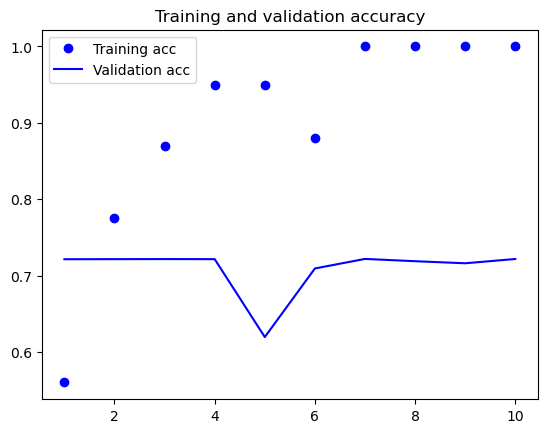

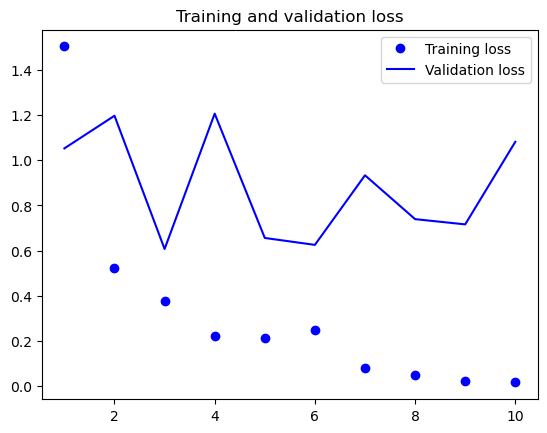

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 125ms/step - loss: 0.6759 - acc: 0.6000 - val_loss: 0.6370 - val_acc: 0.7218
Epoch 2/10
7/7 [==============================

In [18]:
test_dir = os.path.join(imdb_dir, 'aclImdb\\test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [19]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

539/539 [==============================] - 1s 2ms/step - loss: 1.0522 - acc: 0.7286


[1.0522172451019287, 0.728643536567688]

# 2.Understanding recurrent neural networks
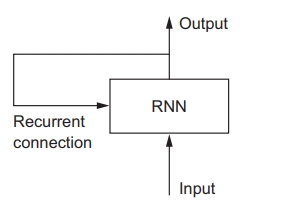

In [20]:
#Numpy implementation of a simple RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In [21]:
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

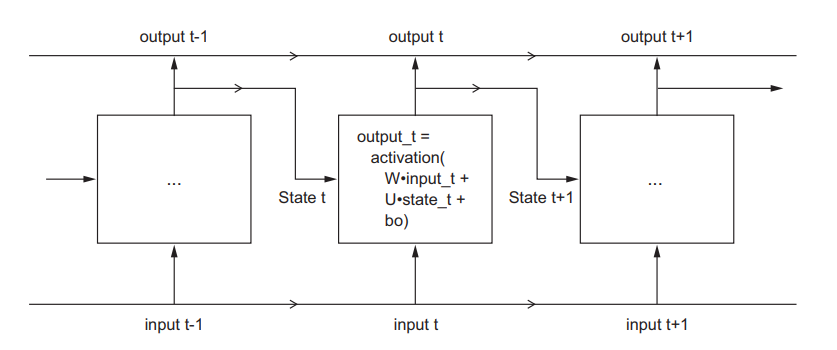

# 2.1 A recurrent layer in Keras

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [23]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [24]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.datasets import imdb
from tensorflow.keras.utils import pad_sequences
max_features = 10000
maxlen = 500
batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train =pad_sequences(input_train, maxlen=maxlen)
input_test =pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [26]:
from keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 17s 98ms/step - loss: 0.6013 - acc: 0.6735 - val_loss: 0.4741 - val_acc: 0.7896
Epoch 2/10
157/157 [==============================] - 18s 113ms/step - loss: 0.3908 - acc: 0.8360 - val_loss: 0.3595 - val_acc: 0.8538
Epoch 3/10
157/157 [==============================] - 15s 96ms/step - loss: 0.3019 - acc: 0.8795 - val_loss: 0.4768 - val_acc: 0.7922
Epoch 4/10
157/157 [==============================] - 19s 119ms/step - loss: 0.2560 - acc: 0.8981 - val_loss: 0.4011 - val_acc: 0.8512
Epoch 5/10
157/157 [==============================] - 15s 97ms/step - loss: 0.1991 - acc: 0.9258 - val_loss: 0.3672 - val_acc: 0.8500
Epoch 6/10
157/157 [==============================] - 19s 124ms/step - loss: 0.1569 - acc: 0.9431 - val_loss: 0.4340 - val_acc: 0.8148
Epoch 7/10
157/157 [==============================] - 14s 91ms/step - loss: 0.1288 - acc: 0.9578 - val_loss: 0.4591 - val_acc: 0.8184
Epoch 8/10
157/157 [==============================] - 19s 1

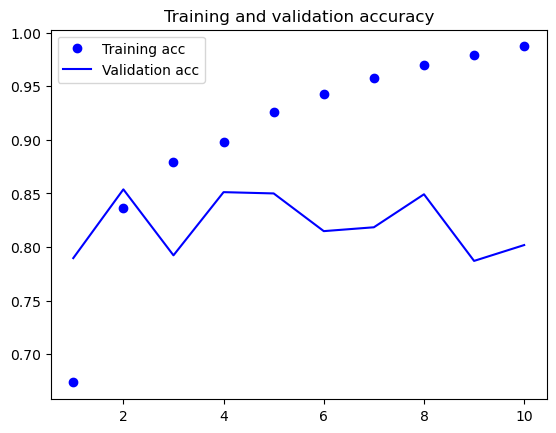

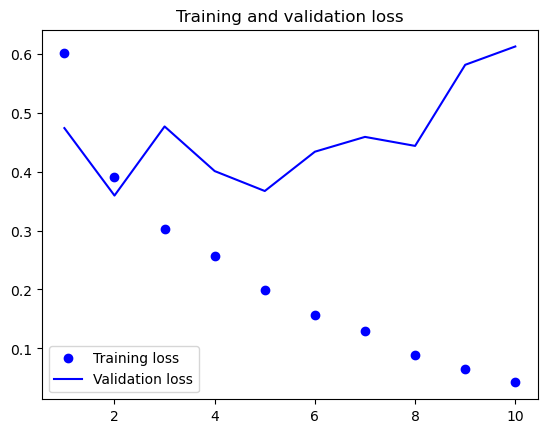

In [27]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 2.2  Understanding the LSTM and GRU layers

Going from a SimpleRNN to an LSTM: adding a carry track
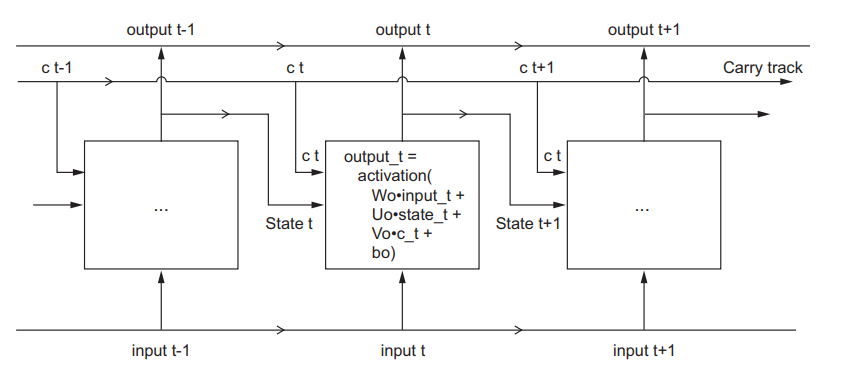
LSTM
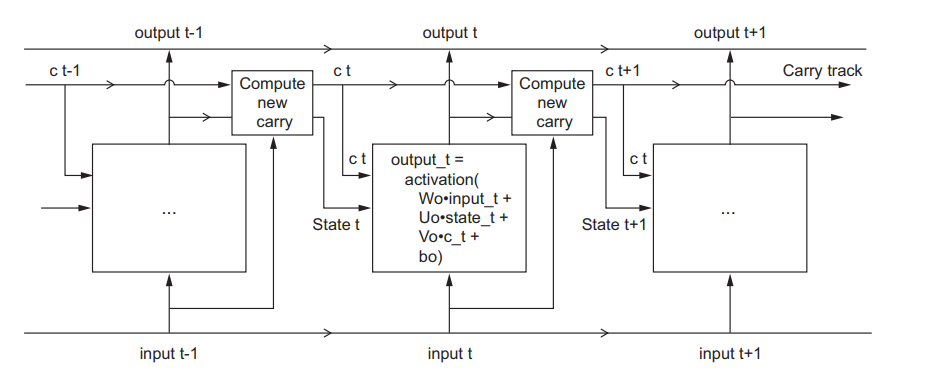

# 2.3 A concrete LSTM example in Keras

In [28]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(input_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 44s 262ms/step - loss: 0.6029 - acc: 0.6565 - val_loss: 0.4886 - val_acc: 0.7864
Epoch 2/10
157/157 [==============================] - 38s 240ms/step - loss: 0.3598 - acc: 0.8513 - val_loss: 0.3965 - val_acc: 0.8436
Epoch 3/10
157/157 [==============================] - 38s 241ms/step - loss: 0.2790 - acc: 0.8906 - val_loss: 0.3639 - val_acc: 0.8592
Epoch 4/10
157/157 [==============================] - 40s 252ms/step - loss: 0.2363 - acc: 0.9107 - val_loss: 0.3178 - val_acc: 0.8676
Epoch 5/10
157/157 [==============================] - 40s 253ms/step - loss: 0.2027 - acc: 0.9250 - val_loss: 0.6055 - val_acc: 0.8234
Epoch 6/10
157/157 [==============================] - 38s 241ms/step - loss: 0.1821 - acc: 0.9336 - val_loss: 0.3426 - val_acc: 0.8676
Epoch 7/10
157/157 [==============================] - 39s 246ms/step - loss: 0.1637 - acc: 0.9403 - val_loss: 0.3551 - val_acc: 0.8622
Epoch 8/10
157/157 [==============================] - 3

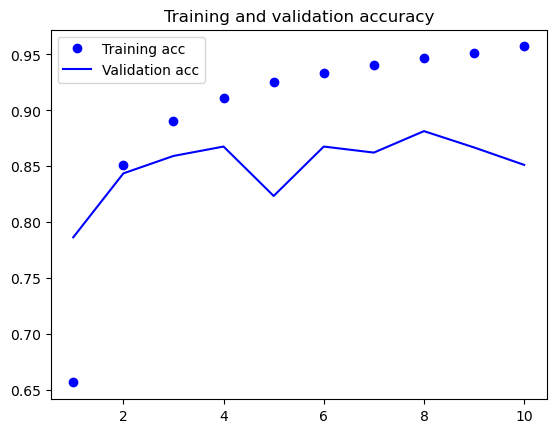

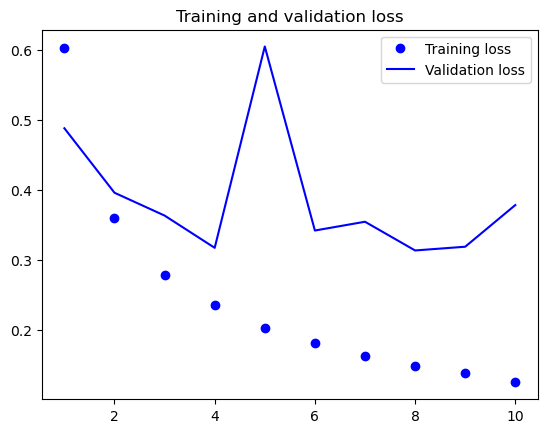

In [29]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3.Advanced use of recurrent neural networks

# 3.1 A temperature-forecasting problem

In [13]:
import os
data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [14]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


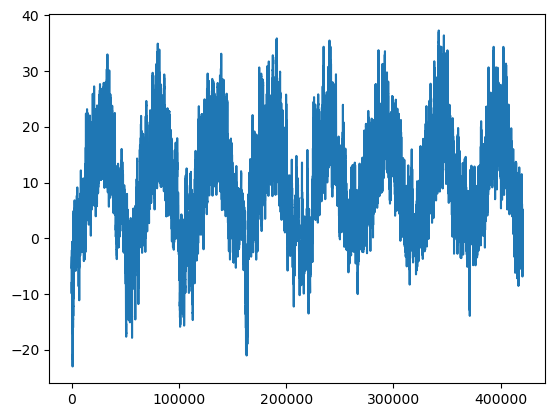

In [15]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

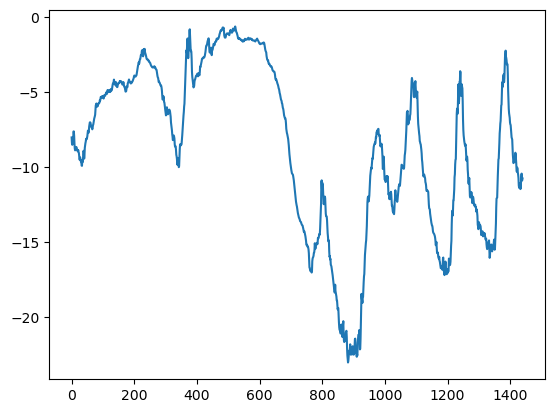

In [16]:
plt.plot(range(1440), temp[:1440])


# 3.2  Preparing the data

In [17]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [18]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

# 3.3 A common-sense, non-machine-learning baseline

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.28969941979609765


In [9]:
celsius_mae = 0.29 * std[1]

# 3.4 A basic machine-learning approach

In [39]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/5


C:\Users\Hi\AppData\Local\Temp\ipykernel_20984\2054328436.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)


500/500 [==============================] - 725s 1s/step - loss: 1.3321 - val_loss: 0.6166
Epoch 2/5
500/500 [==============================] - 892s 2s/step - loss: 0.4124 - val_loss: 0.3242
Epoch 3/5
500/500 [==============================] - 888s 2s/step - loss: 0.2839 - val_loss: 0.3108
Epoch 4/5
500/500 [==============================] - 870s 2s/step - loss: 0.2627 - val_loss: 0.3211
Epoch 5/5
500/500 [==============================] - 914s 2s/step - loss: 0.2506 - val_loss: 0.3031


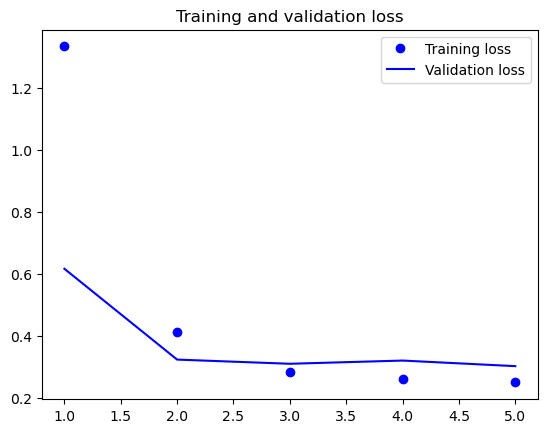

In [40]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3.5 A first recurrent baseline

In [41]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/5


C:\Users\Hi\AppData\Local\Temp\ipykernel_20984\3616785242.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)


500/500 [==============================] - 3727s 7s/step - loss: 0.3028 - val_loss: 0.2760
Epoch 2/5
500/500 [==============================] - 3515s 7s/step - loss: 0.2840 - val_loss: 0.2644
Epoch 3/5
500/500 [==============================] - 3272s 7s/step - loss: 0.2771 - val_loss: 0.2769
Epoch 4/5
500/500 [==============================] - 2997s 6s/step - loss: 0.2714 - val_loss: 0.2645
Epoch 5/5
500/500 [==============================] - 9676s 19s/step - loss: 0.2670 - val_loss: 0.2622


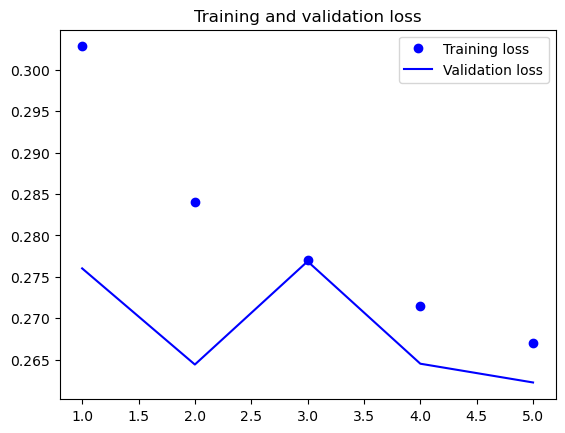

In [42]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3.6 Using recurrent dropout to fight overfitting

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 4221s 8s/step - loss: 0.3216 - val_loss: 0.2777
Epoch 2/5
500/500 [==============================] - 3431s 7s/step - loss: 0.3054 - val_loss: 0.2756
Epoch 3/5
500/500 [==============================] - 3618s 7s/step - loss: 0.2996 - val_loss: 0.2723
Epoch 4/5
500/500 [==============================] - 3572s 7s/step - loss: 0.2943 - val_loss: 0.2777
Epoch 5/5
500/500 [==============================] - 3564s 7s/step - loss: 0.2936 - val_loss: 0.2666


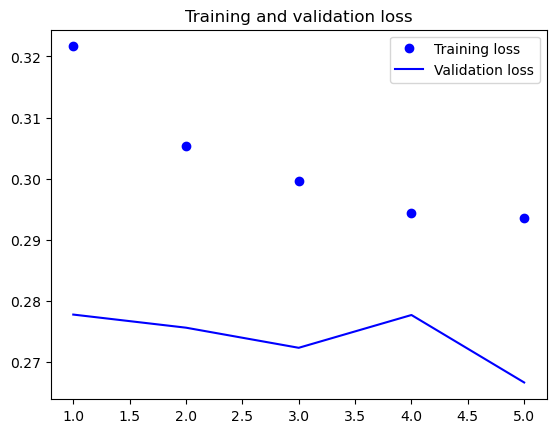

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3.7 Stacking recurrent layers

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,steps_per_epoch=500,epochs=3,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/3
500/500 [==============================] - 453s 887ms/step - loss: 0.3092 - val_loss: 0.2735
Epoch 2/3
500/500 [==============================] - 499s 998ms/step - loss: 0.2953 - val_loss: 0.2835
Epoch 3/3
500/500 [==============================] - 519s 1s/step - loss: 0.2884 - val_loss: 0.2694


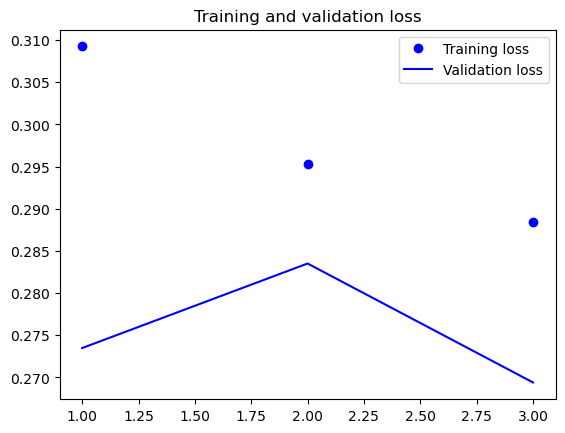

In [27]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3.8 Using bidirectional RNNs

In [8]:
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras import layers
from keras.models import Sequential
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [9]:
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 94s 569ms/step - loss: 0.5945 - acc: 0.6650 - val_loss: 0.4375 - val_acc: 0.8160
Epoch 2/10
157/157 [==============================] - 88s 559ms/step - loss: 0.3921 - acc: 0.8407 - val_loss: 0.4160 - val_acc: 0.8250
Epoch 3/10
157/157 [==============================] - 88s 563ms/step - loss: 0.3128 - acc: 0.8811 - val_loss: 0.4024 - val_acc: 0.8240
Epoch 4/10
157/157 [==============================] - 91s 580ms/step - loss: 0.2743 - acc: 0.8978 - val_loss: 0.3113 - val_acc: 0.8798
Epoch 5/10
157/157 [==============================] - 101s 647ms/step - loss: 0.2413 - acc: 0.9123 - val_loss: 0.4383 - val_acc: 0.8216
Epoch 6/10
157/157 [==============================] - 92s 586ms/step - loss: 0.2169 - acc: 0.9241 - val_loss: 0.3502 - val_acc: 0.8488
Epoch 7/10
157/157 [==============================] - 92s 588ms/step - loss: 0.1945 - acc: 0.9289 - val_loss: 0.4911 - val_acc: 0.7734
Epoch 8/10
157/157 [==============================] - 

In [10]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 165s 975ms/step - loss: 0.6900 - acc: 0.5301 - val_loss: 0.6395 - val_acc: 0.6482
Epoch 2/10
157/157 [==============================] - 168s 1s/step - loss: 0.5089 - acc: 0.7659 - val_loss: 0.4218 - val_acc: 0.8358
Epoch 3/10
157/157 [==============================] - 167s 1s/step - loss: 0.3467 - acc: 0.8640 - val_loss: 0.3122 - val_acc: 0.8794
Epoch 4/10
157/157 [==============================] - 159s 1s/step - loss: 0.2870 - acc: 0.8928 - val_loss: 0.3267 - val_acc: 0.8654
Epoch 5/10
157/157 [==============================] - 160s 1s/step - loss: 0.2501 - acc: 0.9101 - val_loss: 0.3274 - val_acc: 0.8686
Epoch 6/10
157/157 [==============================] - 167s 1s/step - loss: 0.2178 - acc: 0.9220 - val_loss: 0.3181 - val_acc: 0.8702
Epoch 7/10
157/157 [==============================] - 171s 1s/step - loss: 0.2061 - acc: 0.9292 - val_loss: 0.5398 - val_acc: 0.8370
Epoch 8/10
157/157 [==============================] - 173s 1s/step

In [12]:
# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop
# model = Sequential()
# model.add(layers.Bidirectional(
# layers.GRU(32), input_shape=(None, float_data.shape[-1])))
# model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)

# 4.Sequence processing with convnets
# 4.1 Understanding 1D convolution for sequence data

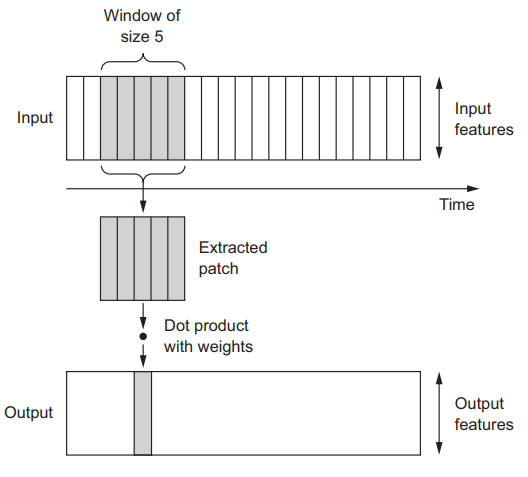

# 4.3 Implementing a 1D convnet

In [3]:
from keras.datasets import imdb
from keras.utils import pad_sequences
max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test =pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

C:\Users\Hi\anaconda3\lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


157/157 [==============================] - 48s 295ms/step - loss: 0.7754 - acc: 0.5056 - val_loss: 0.6889 - val_acc: 0.5472
Epoch 2/10
157/157 [==============================] - 46s 292ms/step - loss: 0.6749 - acc: 0.6412 - val_loss: 0.6755 - val_acc: 0.6176
Epoch 3/10
157/157 [==============================] - 48s 309ms/step - loss: 0.6458 - acc: 0.7462 - val_loss: 0.6490 - val_acc: 0.6640
Epoch 4/10
157/157 [==============================] - 46s 293ms/step - loss: 0.5916 - acc: 0.7976 - val_loss: 0.5706 - val_acc: 0.7858
Epoch 5/10
157/157 [==============================] - 45s 288ms/step - loss: 0.4762 - acc: 0.8317 - val_loss: 0.4471 - val_acc: 0.8232
Epoch 6/10
157/157 [==============================] - 46s 294ms/step - loss: 0.3716 - acc: 0.8622 - val_loss: 0.4001 - val_acc: 0.8498
Epoch 7/10
157/157 [==============================] - 48s 306ms/step - loss: 0.3117 - acc: 0.8888 - val_loss: 0.3957 - val_acc: 0.8586
Epoch 8/10
157/157 [==============================] - 48s 306ms/st

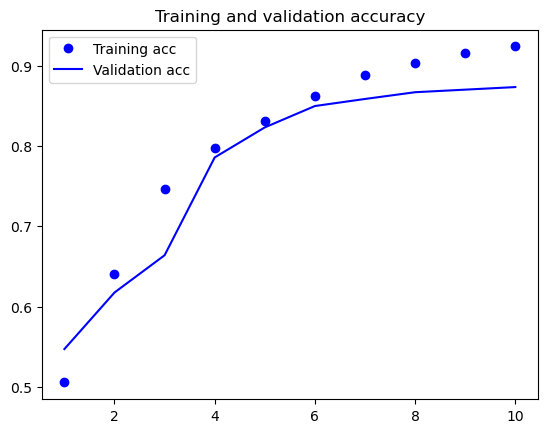

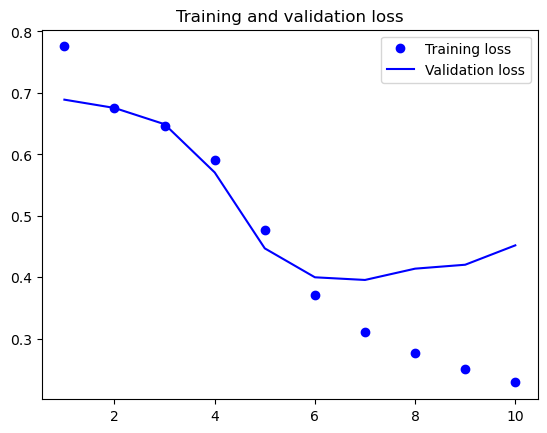

In [5]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 4.4 Combining CNNs and RNNs to process long sequences
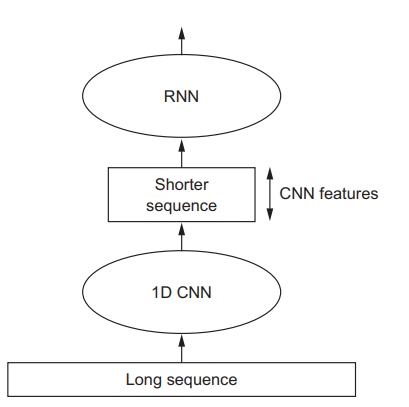

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,steps_per_epoch=500,epochs=3,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/3
500/500 [==============================] - 1674s 3s/step - loss: 0.4185 - val_loss: 0.4348
Epoch 2/3
500/500 [==============================] - 1827s 4s/step - loss: 0.3617 - val_loss: 0.4319
Epoch 3/3
500/500 [==============================] - 1874s 4s/step - loss: 0.3339 - val_loss: 0.4363


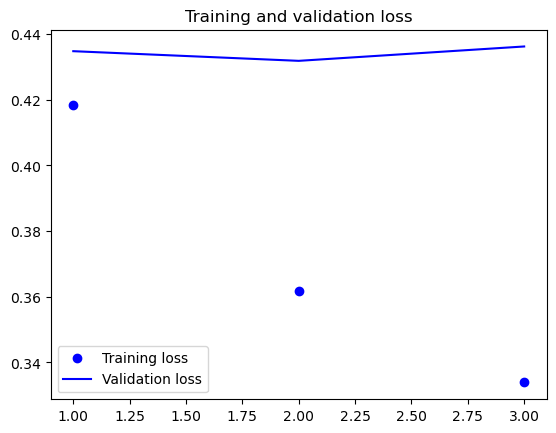

In [21]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
#Model combining a 1D convolutional base and a GRU layer
step = 3
lookback = 720
delay = 144
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step)
test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

In [24]:
history = model.fit(train_gen,steps_per_epoch=500,epochs=3,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/3
500/500 [==============================] - 72s 133ms/step - loss: 0.3322 - val_loss: 0.3038
Epoch 2/3
500/500 [==============================] - 65s 129ms/step - loss: 0.2968 - val_loss: 0.2842
Epoch 3/3
500/500 [==============================] - 68s 136ms/step - loss: 0.2832 - val_loss: 0.2862


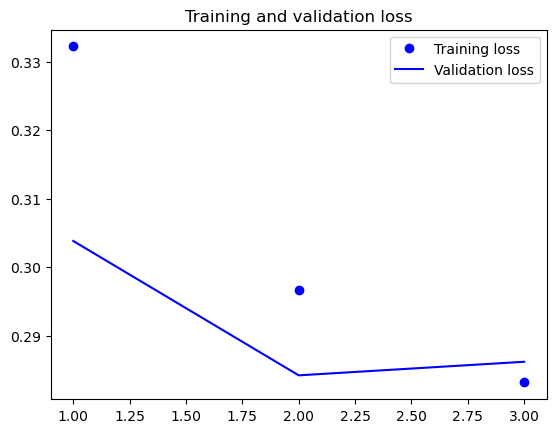

In [25]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()